Supporting material:
This article explains which encoding method should be used for categorical values and why
https://samriddhl.medium.com/binary-encoding-vs-one-hot-encoding-choosing-the-right-approach-for-your-ml-models-9be4533e8772 

## Step 1: Remove Useless columns
In this step, we load all **Shopify** order files and combine them into a single DataFrame. We then select only valuable columns for our models.
Columns we removed are:

In [ ]:
import pandas as pd
import os

RAW_DATA_PATH = os.path.join("..", "resources", "data", "raw", "clv")
PROCESSED_DATA_PATH = os.path.join("..", "resources", "data", "processed", "clv")
output_path = os.path.join(PROCESSED_DATA_PATH, "1_orders_selected_columns.csv")

# File paths
order_files = [
    os.path.join(RAW_DATA_PATH, "orders_export_2.csv"),
    os.path.join(RAW_DATA_PATH, "orders_export_3.csv"),
    os.path.join(RAW_DATA_PATH, "orders_export_1.csv"),
]

##########step 1 all orders in one dataframe##########
# all orders tables in one dataframe
raw_orders_df = pd.concat([pd.read_csv(file) for file in order_files], ignore_index=True)
################step 2 Keep only usefull columns###############

orders_cleaned_columns = raw_orders_df[["Name", "Email", # identifiers
                                        "Total", # order total
                                        "Discount Amount", 
                                        "Created at", # order creation date
                                        "Lineitem quantity",
                                        "Lineitem price",
                                        "Refunded Amount"]]

# columns that we can add later are:
# country,
# Accepts Marketing
# shipping city

orders_cleaned_columns.to_csv(output_path, index=False)
orders_cleaned_columns.head()

## Step 2: Normalize strings, dates, numeric values and drop rows where the email is missing
Columns with a missing email have an uknown customer, there is no value in predicting the clv for unknown customers

In [ ]:
input_path = os.path.join(PROCESSED_DATA_PATH, "1_orders_selected_columns.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "2_orders_normalized_columns.csv")
df = pd.read_csv(input_path)

# Normalize columns
df["Created at"] = pd.to_datetime(df["Created at"], format="ISO8601")
cols_to_float = ["Total", "Discount Amount", "Lineitem quantity", "Lineitem price", "Refunded Amount"]
for col in cols_to_float:
    raw_orders_df[col] = pd.to_numeric(raw_orders_df[col])

df["Email"] = df["Email"].str.lower().str.strip()
df = df[df["Email"].notna() & (df["Email"] != "")]
df.reset_index(drop=True, inplace=True)
df.to_csv(output_path, index=False)

## Step 3: Combine Multiple Rows Into One Per Order
Shopify splits a single order into multiple rows if it contains multiple unique items. This step identifies such rows using the 'Email' and 'Name' (which is the id of an order) fields, and merges them by combining their line items into a single list. Additionally, duplicate orders are filtered to keep only the fulfilled ones. The result is a dataset where each order occupies one row.

In [ ]:
orders_file = os.path.join(PROCESSED_DATA_PATH, "2_orders_normalized_columns.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "3_orders_have_one_row.csv")

orders_df = pd.read_csv(orders_file)

# Create structured line item object per row including price
orders_df["Lineitem_object"] = orders_df.apply(
    lambda row: {
        "qty": int(row["Lineitem quantity"]),
        "price": float(row["Lineitem price"])
    },
    axis=1
)

# Group all line items per order
lineitems_grouped = orders_df.groupby(["Name", "Email"])["Lineitem_object"].agg(list).reset_index()

# Keep only the first row per order for metadata
first_rows = orders_df.drop_duplicates(subset=["Name", "Email"], keep="first")

# Merge grouped line items back into first rows
merged_orders = pd.merge(
    first_rows.drop(columns=["Lineitem quantity", "Lineitem price", "Lineitem_object"]),
    lineitems_grouped,
    on=["Name", "Email"],
    how="left"
)

# Rename column for clarity
merged_orders.rename(columns={"Lineitem_object": "Lineitems"}, inplace=True)

# Save the final one-row-per-order file
merged_orders.to_csv(output_path, index=False)


## Step 4: Feature engineering for Line items
for now the lineitems column per order looks like this:\
`[{'qty': 1, 'price': 29.95}, {'qty': 1, 'price': 34.95}, {'qty': 1, 'price': 29.95}, {'qty': 1, 'price': -4.74}]`\
We want to remove this column because it is unprocesseable for our ML models, it will be replaced by.
- average item price 
- amount of items
optionally we can later add the maximum and minimum item value
We also notice that some items have a negative value, these are discount items. We will replace those with two columns:
- discount_item_applied 
- discount_item_value

In [ ]:
import ast
input_path = os.path.join(PROCESSED_DATA_PATH, "3_orders_have_one_row.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "4_orders_lineitems_summarized.csv")

def summarize_lineitems(items):
    discounted_items = [item for item in items if item["price"] < 0]
    regular_items = [item for item in items if item["price"] >= 0]

    discount_item_applied = len(discounted_items) > 0
    discount_item_value = sum(item["price"] for item in discounted_items)

    total_qty = sum(item["qty"] for item in regular_items)
    avg_item_price = (
        sum(item["qty"] * item["price"] for item in regular_items) / total_qty
        if total_qty > 0 else 0
    )

    return pd.Series({
        "total_qty": total_qty,
        "avg_item_price": avg_item_price,
        "discount_item_applied": discount_item_applied,
        "discount_item_value": discount_item_value
    })

# Apply to dataframe
orders_df = pd.read_csv(input_path)
orders_df["Lineitems"] = orders_df["Lineitems"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
lineitem_summary = orders_df["Lineitems"].apply(summarize_lineitems)
orders_df = pd.concat([orders_df, lineitem_summary], axis=1)
orders_df.drop(columns=["Lineitems"], inplace=True)
orders_df.to_csv(output_path, index=False)

dtype('bool')

## Step 5 Orders: One row per customer
This script transforms raw Shopify orders into a clean, customer-level dataset for modeling.  
It extracts the year-month from each order date and groups by customer and month to compute:  
- total spent, total discounts, refunded amounts, quantity, and average item price  
- total number of orders and average order value per month  

The data is pivoted to wide format (1 row per customer), with one column per metric per month.  
It also computes lifetime metrics like total orders, total items, and average lifetime order value.  
This structure is ideal for CLV modeling as it captures both **temporal trends** and **lifetime behavior**. 

In [49]:
import pandas as pd
import os

# Paths
input_path = os.path.join(PROCESSED_DATA_PATH, "4_orders_lineitems_summarized.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "5_customer_monthly_lifetime_features.csv")

# Load data
df = pd.read_csv(input_path)

# Ensure 'Created at' is a proper datetime with timezone support
df["Created at"] = pd.to_datetime(df["Created at"], utc=True)

# Extract Year-Month for time grouping
df["year_month"] = df["Created at"].dt.to_period("M").astype(str)

# Monthly aggregation per customer
monthly_agg = df.groupby(["Email", "year_month"]).agg(
    total_spent=("Total", "sum"),
    total_discount_amount=("Discount Amount", "sum"),
    total_refunded_amount=("Refunded Amount", "sum"),
    total_item_quantity=("total_qty", "sum"),
    avg_item_price=("avg_item_price", "mean"),
    discount_item_applied=("discount_item_applied", "max"),
    discount_item_value=("discount_item_value", "sum"),
    total_amount_of_orders=("Name", "nunique"),
    avg_order_value=("Total", "mean")
).reset_index()

monthly_agg["average_item_qty_per_order"] = (
    monthly_agg["total_item_quantity"] / monthly_agg["total_amount_of_orders"]
)

# Pivot to wide format (Email = index)
monthly_pivot = monthly_agg.pivot(index="Email", columns="year_month")
monthly_pivot.columns = [f"{metric}_{month}" for metric, month in monthly_pivot.columns]

for col in monthly_pivot.columns:
    if "discount_item_applied" in col:
        monthly_pivot[col] = monthly_pivot[col].astype(bool)
        
# Lifetime aggregates per customer
lifetime_agg = df.groupby("Email").agg(
    lifetime_amount_items=("total_qty", "sum"),
    lifetime_amount_orders=("Name", "nunique"),
    lifetime_avg_order_value=("Total", "mean")
).reset_index()

# Merge monthly and lifetime features
final_df = pd.merge(monthly_pivot.reset_index(), lifetime_agg, on="Email", how="left")

# Save result
final_df.to_csv(output_path, index=False)

C:\Users\AbdulS\AppData\Local\Temp\ipykernel_39716\2283671473.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["Created at"].dt.to_period("M").astype(str)


## Step 6 Klaviyo (optional): Add behavioural features from klaviyo
This might not be needed depending on the model performance, some columns can be useful.
- Email Marketing Consent
- First Active
- Last Active


In [50]:
customers_file = os.path.join(RAW_DATA_PATH, "Klaviyo_everyone_email.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "1_klaviyo_selected_columns.csv")
# Read the Klaviyo customers file
klaviyo_df = pd.read_csv(customers_file)
# Keep only useful columns
klaviyo_cleaned_columns = klaviyo_df[["Email", "Email Marketing Consent", 
                                      "First Active", "Last Active",
                                      "Last Open", "Last Click"]]
# Normalize the Email column
klaviyo_cleaned_columns["Email"] = klaviyo_cleaned_columns["Email"].str.lower().str.strip()
klaviyo_cleaned_columns.to_csv(output_path, index=False)


C:\Users\AbdulS\AppData\Local\Temp\ipykernel_39716\30660488.py:4: DtypeWarning: Columns (6,65,66,68,72) have mixed types. Specify dtype option on import or set low_memory=False.
  klaviyo_df = pd.read_csv(customers_file)
C:\Users\AbdulS\AppData\Local\Temp\ipykernel_39716\30660488.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  klaviyo_cleaned_columns["Email"] = klaviyo_cleaned_columns["Email"].str.lower().str.strip()


## Step 7 Klaviyo (optional)
We creat numerical features of the behavioural features we have:

**First active becomes** -> customer age or days since first active

**Last active becomes** -> customer recency or days since last active

**Email Marketing Consent** can have three values SUBSCRIBED - UNSUBSCRIBED - NEVER_SUBSCRIBED -> We turn those into three binary columns.

In [51]:
from datetime import datetime
import pandas as pd
import os

input_file = os.path.join(PROCESSED_DATA_PATH, "1_klaviyo_selected_columns.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "2_klaviyo_cleaned_columns.csv")

# Load file
klaviyo_df = pd.read_csv(input_file)

# Reference date: the day your pipeline runs
reference_date = pd.to_datetime(datetime.today())

# Normalize email
klaviyo_df["Email"] = klaviyo_df["Email"].str.lower().str.strip()

# Parse dates safely
klaviyo_df["First Active"] = pd.to_datetime(klaviyo_df["First Active"])
klaviyo_df["Last Active"] = pd.to_datetime(klaviyo_df["Last Active"])
klaviyo_df["Last Open"] = pd.to_datetime(klaviyo_df["Last Open"])
klaviyo_df["Last Click"] = pd.to_datetime(klaviyo_df["Last Click"])

# Feature engineering: time deltas
klaviyo_df["_days_since_first_active"] = (reference_date - klaviyo_df["First Active"]).dt.days
klaviyo_df["_days_since_last_active"] = (reference_date - klaviyo_df["Last Active"]).dt.days
klaviyo_df["_days_since_last_open"] = (reference_date - klaviyo_df["Last Open"]).dt.days
klaviyo_df["_days_since_last_click"] = (reference_date - klaviyo_df["Last Click"]).dt.days

# Handle missing values
klaviyo_df["_days_since_first_active"].fillna(9999, inplace=True)
klaviyo_df["_days_since_last_active"].fillna(9999, inplace=True)
klaviyo_df["_days_since_last_open"].fillna(9999, inplace=True)
klaviyo_df["_days_since_last_click"].fillna(9999, inplace=True)

# One-hot encode Email Marketing Consent
klaviyo_df = pd.get_dummies(
    klaviyo_df,
    columns=["Email Marketing Consent"],
    prefix="email_consent"
)

# Final columns to keep: email, engineered features, and encoded consent flags
final_columns = ["Email", "_days_since_first_active", "_days_since_last_active", "_days_since_last_open", "_days_since_last_click"] + \
                [col for col in klaviyo_df.columns if col.startswith("email_consent_")]

klaviyo_cleaned = klaviyo_df[final_columns]

# Save to CSV
klaviyo_cleaned.to_csv(output_path, index=False)

C:\Users\AbdulS\AppData\Local\Temp\ipykernel_39716\795978230.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  klaviyo_df["_days_since_first_active"].fillna(9999, inplace=True)
C:\Users\AbdulS\AppData\Local\Temp\ipykernel_39716\795978230.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

## Step 8: Klaviyo (optional) (only required if step 6 and 7 were done) Merge customer data with customer order trends data
We merge the cleaned Shopify order data with customer profile data from Klaviyo using the 'Email' field. The result is a dataset that combines behavioral (order-based) and demographic (profile-based) information.

In [52]:


input_path_1 = os.path.join(PROCESSED_DATA_PATH, "5_customer_monthly_lifetime_features.csv")
input_path_2 = os.path.join(PROCESSED_DATA_PATH, "2_klaviyo_cleaned_columns.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "8_merged_orders_customers.csv")
orders_df = pd.read_csv(input_path_1)
customers_behaviour_df = pd.read_csv(input_path_2)

merged_df = pd.merge(
    orders_df,
    customers_behaviour_df,
    on="Email",
    how="left"
)
merged_df.to_csv(output_path, index=False)

## Step 9: Klaviyo (optional) fill missing values when a customer is not registered in klaviyo
After merging klaviyo data, we discovered that **278** customers out of **18285** do not have records in klaviyo. The values for all columns coming from klaviyo for these customers are missing. 

In [53]:
input_path = os.path.join(PROCESSED_DATA_PATH, "8_merged_orders_customers.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "9_final_cleaned_dataset.csv")

df = pd.read_csv(input_path)

df["_days_since_first_active"].fillna(9999, inplace=True)
df["_days_since_last_active"].fillna(9999, inplace=True)
df["_days_since_last_open"].fillna(9999, inplace=True)
df["_days_since_last_click"].fillna(9999, inplace=True)

df["email_consent_NEVER_SUBSCRIBED"].fillna(False, inplace=True)
df["email_consent_SUBSCRIBED"].fillna(False, inplace=True)
df["email_consent_UNSUBSCRIBED"].fillna(False, inplace=True)

df.to_csv(output_path, index=False)

C:\Users\AbdulS\AppData\Local\Temp\ipykernel_39716\871178096.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["_days_since_first_active"].fillna(9999, inplace=True)
C:\Users\AbdulS\AppData\Local\Temp\ipykernel_39716\871178096.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

## Step 10 remove all dataleakage prone columns and create target month column.

In [70]:
import pandas as pd
import os
# Load dataset
input_path = os.path.join(PROCESSED_DATA_PATH, "9_final_cleaned_dataset.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "10_dataset_no_leakage_clv_target.csv")
df = pd.read_csv(input_path)


# Define target months
target_months = ["2025-01", "2025-02", "2025-03"]

# -------------------------------
# Step 1: Create CLV target label
# -------------------------------
df["CLV_Jan_to_Mar_2025"] = df[[f"total_spent_{m}" for m in target_months if f"total_spent_{m}" in df.columns]].sum(axis=1)

# -------------------------------
# Step 2: Adjust leakage-prone features
# -------------------------------

# A) total_amount_of_orders (remove target-month orders)
orders_target_cols = [f"total_amount_of_orders_{m}" for m in target_months if f"total_amount_of_orders_{m}" in df.columns]
df["orders_in_target_months"] = df[orders_target_cols].sum(axis=1)
df["total_amount_of_orders_no_target"] = df["lifetime_amount_orders"] - df["orders_in_target_months"]

# B) total_item_quantity (remove target-month items)
items_target_cols = [f"total_item_quantity_{m}" for m in target_months if f"total_item_quantity_{m}" in df.columns]
df["items_in_target_months"] = df[items_target_cols].sum(axis=1)
df["total_amount_of_items_bought_no_target"] = df["lifetime_amount_items"] - df["items_in_target_months"]

# C) avg_lifetime_order_value (recalculate without target months)
pre_target_months = [col.split("_")[-1] for col in df.columns if col.startswith("total_spent_") and col.split("_")[-1] < "2025-01"]
spend_pre_target_cols = [f"total_spent_{m}" for m in pre_target_months if f"total_spent_{m}" in df.columns]
order_pre_target_cols = [f"total_amount_of_orders_{m}" for m in pre_target_months if f"total_amount_of_orders_{m}" in df.columns]

pre_target_spend = df[spend_pre_target_cols].sum(axis=1)
pre_target_orders = df[order_pre_target_cols].sum(axis=1)
pre_target_orders = pre_target_orders.mask(pre_target_orders == 0, pd.NA)

df["avg_lifetime_order_value_no_target"] = pre_target_spend / pre_target_orders

# -------------------------------
# Step 3: Clean up intermediate columns
# -------------------------------
df.drop(columns=["orders_in_target_months", "items_in_target_months", "lifetime_amount_items", "lifetime_amount_orders", "lifetime_avg_order_value"], inplace=True)

# -------------------------------
# Step 4: Drop all features that contain any of the target months
# -------------------------------
df = df[[col for col in df.columns if not any(m in col for m in target_months)]]

# -------------------------------
# Step 5: Save output
# -------------------------------
df.to_csv(output_path, index=False)


## Step 9: Train/Test Split

To evaluate how well our model generalizes to unseen customers, we split our dataset into training and testing sets.

We use an 80/20 split, a common practice in supervised learning.


In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split

input_path = os.path.join(PROCESSED_DATA_PATH, "10_dataset_no_leakage_clv_target.csv")
df = pd.read_csv(input_path)

# Define target column
target = "CLV_Jan_to_Mar_2025"

# Preserve Email column separately for traceability
email_series = df["Email"]

# Prepare features and target
X = df.drop(columns=[target, "Email"])
y = df[target]

# Split while maintaining email tracking
X_train, X_test, y_train, y_test, emails_train, emails_test = train_test_split(
    X, y, email_series, test_size=0.2, random_state=42
)

## Step 10: Baseline for CLV Prediction
Zero Spending: Predict 0 for all customers.

Global Average: Predict average of 3-month spend across all customers.

Customer-Specific Monthly Average × 3: Predict Total Amount Spent / # active months × 3.

In [72]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Create and train dummy model
# dummy = DummyRegressor(strategy="median")
dummy = DummyRegressor(strategy="constant", constant=0.00)
# dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

# Predict and evaluate
y_pred_dummy = dummy.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_dummy)
rmse = root_mean_squared_error(y_test, y_pred_dummy)
r2 = r2_score(y_test, y_pred_dummy)

print("Dummy Regressor (constant):")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.2f}")

Dummy Regressor (constant):
MAE  = 7.63
RMSE = 30.41
R²   = -0.07


## Step 10: Choose, Train, and Evaluate Model

We will use **XGBoost Regressor**, a powerful and efficient model for tabular data.

### Why XGBoost:
- Performs well on structured data
- Handles missing values internally
- Provides feature importance insights
- Scales well for large datasets

We will train the model and evaluate its performance using:
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² Score (explained variance)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define the model
xgb = XGBRegressor(
    n_estimators=100,       # number of trees
    learning_rate=0.1,      # step size shrinkage
    max_depth=6,            # how deep each tree can go
    subsample=0.8,          # random row sampling
    colsample_bytree=0.8,   # random column sampling per tree
    random_state=42,
    n_jobs=-1               # use all cores
)

# Train the model
xgb.fit(X_train, y_train)

# Predict on test set
y_pred = xgb.predict(X_test)

# Evaluate
mae_xgboost = mean_absolute_error(y_test, y_pred)
rmse_xgboost = root_mean_squared_error(y_test, y_pred)
r2_xgboost = r2_score(y_test, y_pred)

print("XGBoost Results:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.2f}")

XGBoost Results:
MAE  = 6.45
RMSE = 21.48
R²   = 0.47


Great the model just got 47% accuracy.
## let's plot the results

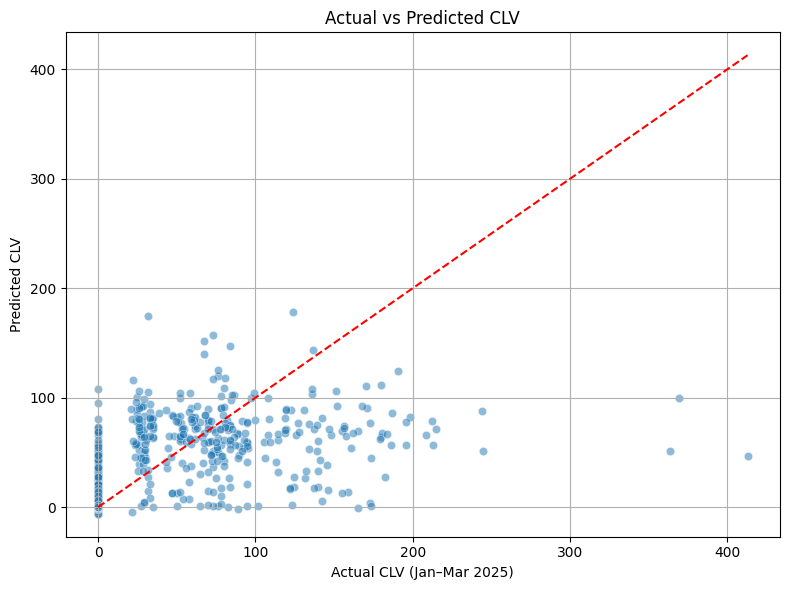

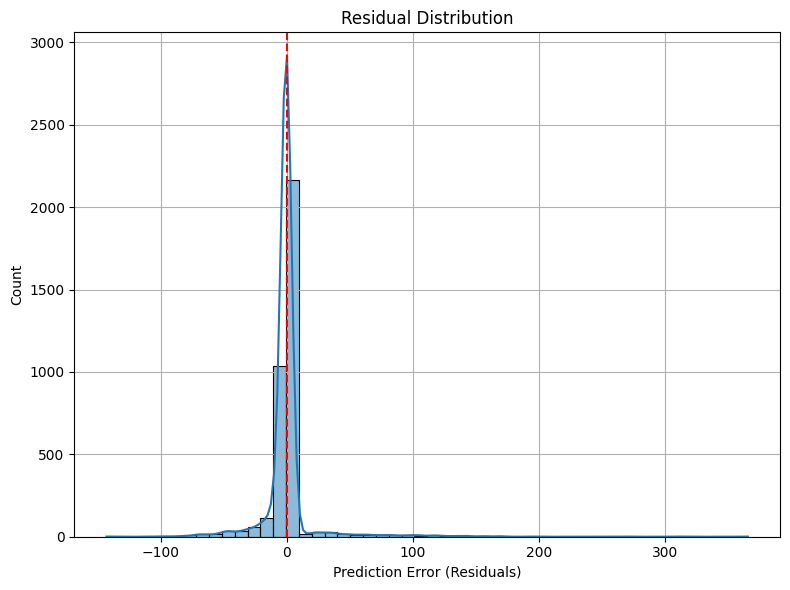

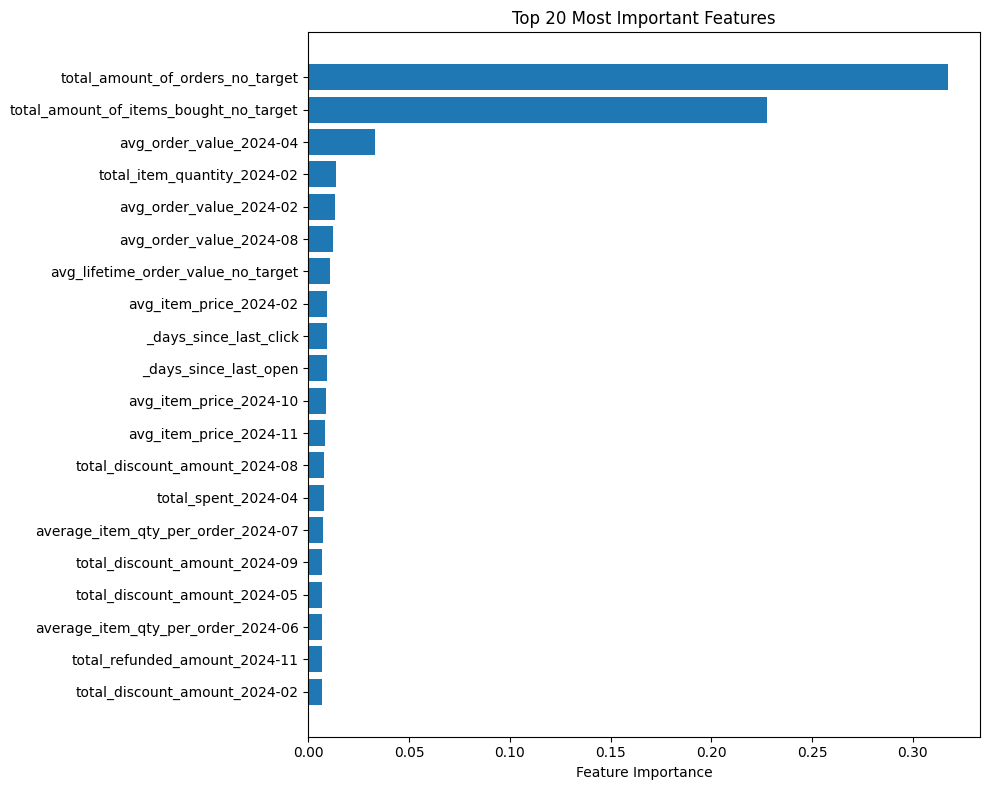

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model performance metrics
rmse = rmse_xgboost
mae = mae_xgboost
r2 = r2_xgboost
### Scatter plot of actual vs predicted CLV
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual CLV (Jan–Mar 2025)")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted CLV")
plt.grid(True)
plt.tight_layout()
plt.show()

### Risidual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Prediction Error (Residuals)")
plt.title("Residual Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature importance plot
importances = xgb.feature_importances_
feature_names = X_train.columns

# Sort by importance
sorted_idx = importances.argsort()[-20:]  # Top 20 features

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features")
plt.tight_layout()
plt.show()


## Let's do the same with Linear regression

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
mae_linear_regression = mean_absolute_error(y_test, y_pred_lr)
rmse_linear_regression = root_mean_squared_error(y_test, y_pred_lr)
r2_linear_regression = r2_score(y_test, y_pred_lr)

print("Linear Regression Results:")
print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²   = {r2:.2f}")


Linear Regression Results:
MAE  = 6.45
RMSE = 21.48
R²   = 0.47


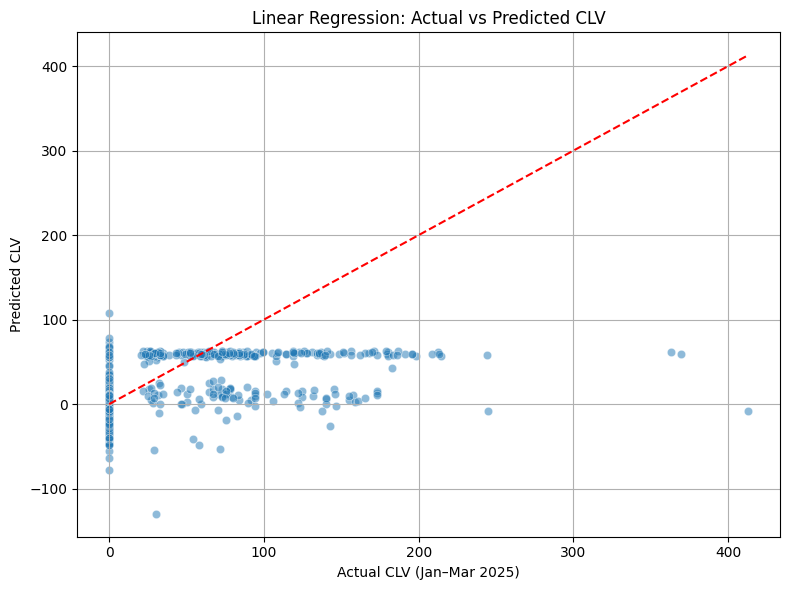

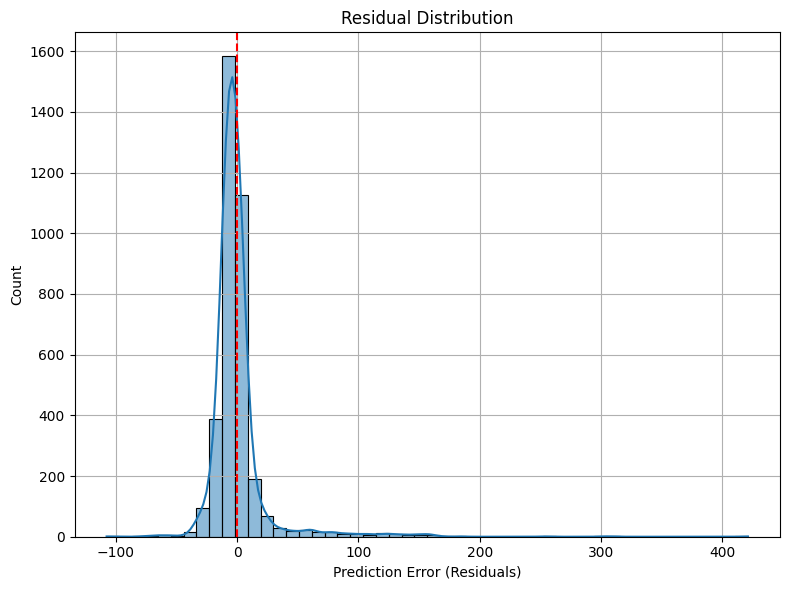

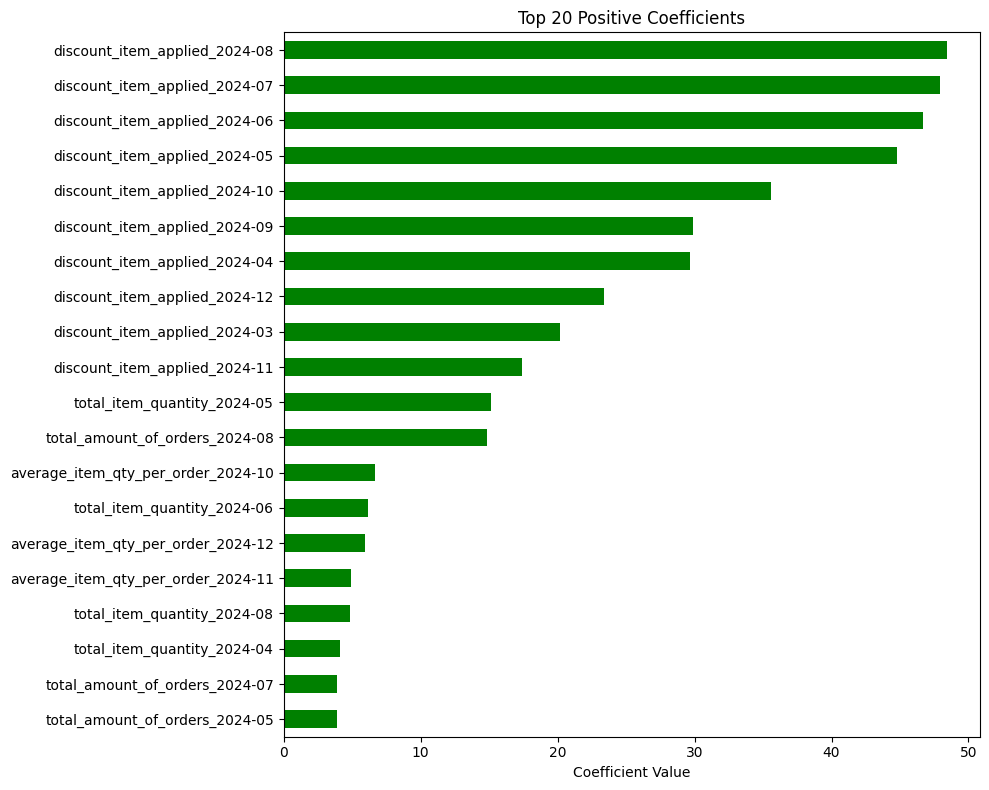

In [76]:
# === Plot 1: Actual vs Predicted ===
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual CLV (Jan–Mar 2025)")
plt.ylabel("Predicted CLV")
plt.title("Linear Regression: Actual vs Predicted CLV")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 2: Residuals Distribution ===
residuals = y_test - y_pred_lr
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Prediction Error (Residuals)")
plt.title("Residual Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Plot 3: Feature Coefficients ===
coefs = pd.Series(lr_model.coef_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
coefs.head(20).plot(kind='barh', color="green")
plt.title("Top 20 Positive Coefficients")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()